In [1]:
import os
import numpy as np
import torch
import torch.nn.functional as F
import matplotlib.pyplot as plt
import matplotlib as mlp

from tqdm import tqdm
from torch.utils.data import TensorDataset, DataLoader

from models.fno import FNO3d
from models.lploss import LpLoss

In [2]:
data_path = '/project/data/l63/'

In [3]:
# Data path
mesh_path = os.path.join(data_path, 'mesh.npy')
priorpdfn_path = os.path.join(data_path, 'prior.npy')

# Read numpy matrices
mesh = torch.from_numpy(np.load(mesh_path).reshape((1, 40, 40, 40, 3)))
priorpdfn = torch.from_numpy(np.load(priorpdfn_path).reshape((-1, 40, 40, 40, 1)))

In [4]:
p = torch.concat([priorpdfn, mesh.repeat(499, 1, 1, 1, 1)], dim=-1)
p = F.pad(p, (0, 0, 0, 0, 0, 0, 0, 0, 1, 0), 'constant', 0)
p.shape

torch.Size([500, 40, 40, 40, 4])

In [5]:
mode1 = 10
mode2 = 10
mode3 = 10
width = 128
model = FNO3d(mode1, mode2, mode3, width, n_blocks=10)

In [6]:
def get_dataset(p, n_steps=10):
    xs = []
    ys = []
    for i in range(0, p.shape[0]-n_steps):
        xs.append(p[i])
        ys.append(p[i+n_steps, ..., 0].unsqueeze(-1))
    x = torch.stack(xs, dim=0)
    y = torch.stack(ys, dim=0)
    return TensorDataset(x, y)

In [7]:
full_ds = get_dataset(p, n_steps=15)
train_size = int(0.8 * len(full_ds))
test_size = len(full_ds) - train_size
train_ds, test_ds = torch.utils.data.random_split(full_ds, 
                                                  [train_size, test_size])


In [8]:
batch_size = 16
train_dl = DataLoader(train_ds, batch_size=batch_size, shuffle=True)
test_dl = DataLoader(test_ds, batch_size=batch_size, shuffle=True)

In [9]:
epochs = 30
e_start = 0
learning_rate = 0.01
scheduler_step = 4
scheduler_gamma = 0.85
learning_rate

0.01

In [10]:
optimizer = torch.optim.Adam(model.parameters(), 
                             lr=learning_rate, weight_decay=1e-4)
scheduler = torch.optim.lr_scheduler.StepLR(optimizer,
                                            step_size=scheduler_step, 
                                            gamma=scheduler_gamma)
myloss = LpLoss(size_average=False)

In [11]:
train_l2 = 0.0
for ep in range(1,epochs+1):
    model.train()
    train_l2 = 0
    test_l2 = 0
    counter = 0
    for x, y in train_dl:
        
        optimizer.zero_grad()
    
        pred = model(x)
        ori_loss = 0

        num_examples = x.shape[0]
        
        # original loss
        # for i in range(batch_size):
        ori_loss += myloss(pred.reshape(num_examples, -1), 
                           y.reshape(num_examples, -1))

        loss = ori_loss
        
        loss.backward()
        optimizer.step()
        train_l2 += loss.item()

        counter += 1
        if counter % 5 == 0:
            print(f'epoch: {ep}, batch: {counter}/{len(train_dl)}, train loss: {loss.item()/batch_size:.4f}')
    
    scheduler.step()
    
    if ep % 2 == 0:
        
        model.eval()
        
        for x, y in test_dl:
        
            pred = model(x)
            ori_loss = 0

            num_examples = x.shape[0]
            ori_loss += myloss(pred.reshape(num_examples, -1), 
                            y.reshape(num_examples, -1))

            test_l2 += ori_loss.item()
        
        print(f'epoch: {ep}, train loss: {train_l2/train_size:.4f}, test loss: {test_l2/test_size:.4f}')
    
    else:
        print(f'epoch: {ep}, train loss: {train_l2/train_size:.4f}')
    
    # lr_ = optimizer.param_groups[0]['lr']
    # if ep % 2 == 0:
    #     PATH = f'saved_models/dP_UFNO_{ep}ep_{width}width_{mode1}m1_{mode2}m2_{train_a.shape[0]}train_{lr_:.2e}lr'
    #     torch.save(model, PATH)

KeyboardInterrupt: 

In [ ]:
def scale(x):
    x_max = x.max()
    x_min = x.min()
    return (x - x_min)/(x_max - x_min)

def plot_pdf(x, y, z, a, p, pred):

    cmap = plt.cm.viridis
    ss = 900
    
    
    fig, ax = plt.subplots(1, 3, figsize=(10, 32), 
                           subplot_kw=dict(projection='3d'), 
                           constrained_layout=True)
    
    norm = mlp.colors.Normalize(vmin=a.min(), vmax=a.max())
    ax[0].scatter(x, y, z, s=scale(a)*ss, color=cmap(norm(a)), alpha=0.5)
    ax[0].set_title('Input')
    
    # norm = mlp.colors.Normalize(vmin=p.min(), vmax=p.max())
    ax[1].scatter(x, y, z, s=scale(p)*ss, color=cmap(norm(p)), alpha=0.5)
    ax[1].set_title('Target')
    
    # norm = mlp.colors.Normalize(vmin=pred.min(), vmax=pred.max())
    ax[2].scatter(x, y, z, s=scale(pred)*ss, color=cmap(norm(pred)), alpha=0.5)
    ax[2].set_title('Prediction (FNO)')


    # ax.autoscale(False)
    ax[0].set(xlabel='x1', ylabel='x2', zlabel='x3')
    ax[1].set(xlabel='x1', ylabel='x2', zlabel='x3')
    ax[2].set(xlabel='x1', ylabel='x2', zlabel='x3')

    plt.show()

In [ ]:
xmesh = mesh[0, :, :, :, 0]
ymesh = mesh[0, :, :, :, 1]
zmesh = mesh[0, :, :, :, 2]

x = xmesh.ravel().numpy()
y = ymesh.ravel().numpy()
z = zmesh.ravel().numpy()

In [ ]:
# model = torch.load('/project/model.pt')

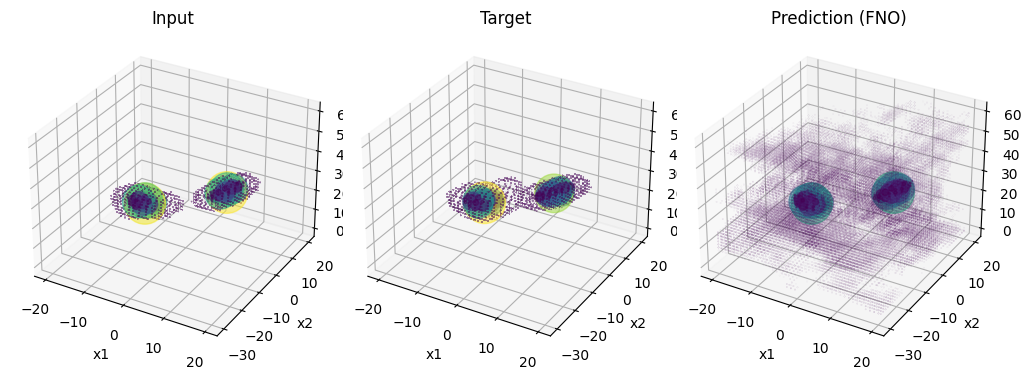

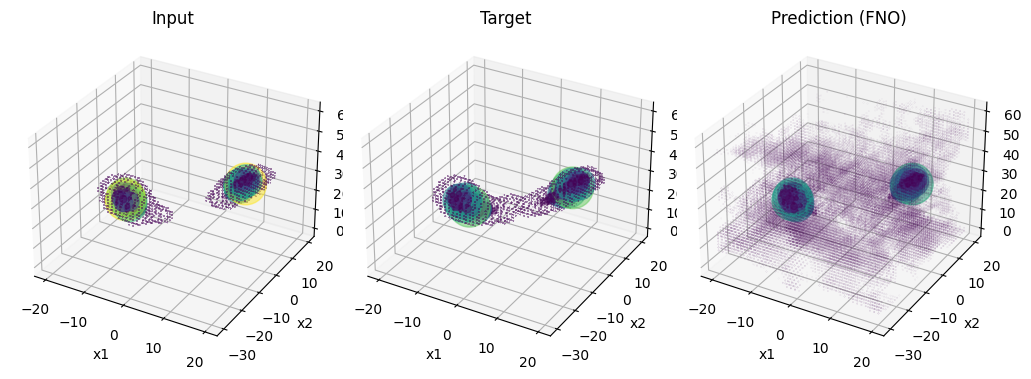

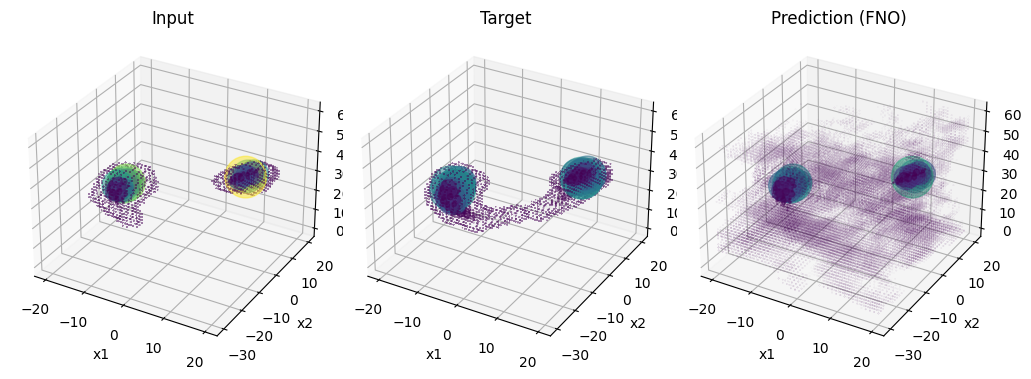

In [ ]:
for ind in range(3, 12, 3):
    a, p = full_ds[ind]
    pred = model(a[None, :, :, :, :]).relu().view(40, 40, 40).detach().numpy()
    p = p.view(40, 40, 40).numpy()
    a = a[...,0].view(40, 40, 40).numpy()
    plot_pdf(x, y, z, a.ravel(), p.ravel(), pred.ravel())

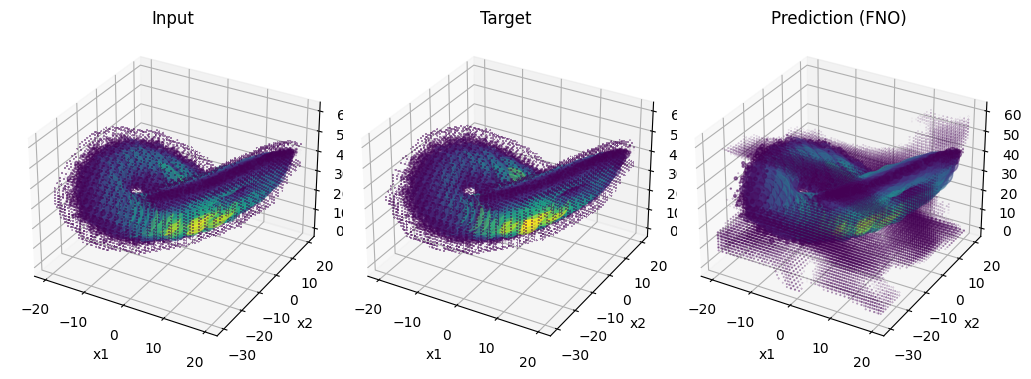

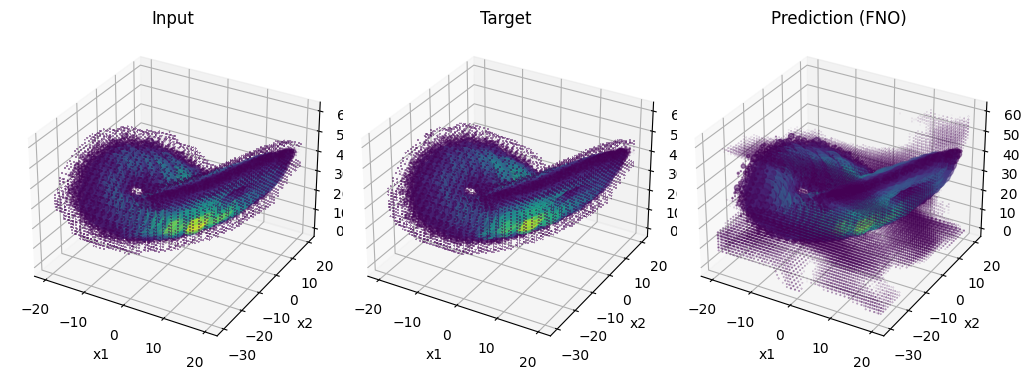

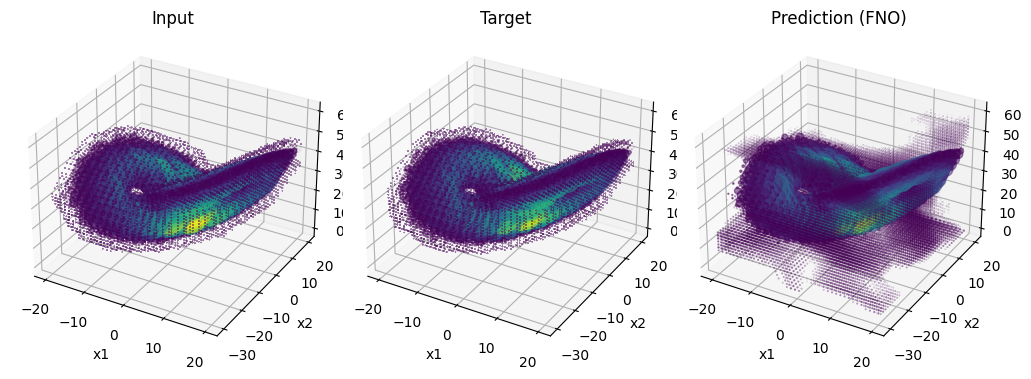

In [ ]:
for ind in range(3, 12, 3):
    n = len(full_ds)
    a, p = full_ds[n//2-ind]
    pred = model(a[None, :, :, :, :]).relu().view(40, 40, 40).detach().numpy()
    p = p.view(40, 40, 40).numpy()
    a = a[...,0].view(40, 40, 40).numpy()
    plot_pdf(x, y, z, a.ravel(), p.ravel(), pred.ravel())